<a href="https://colab.research.google.com/github/candiceevemiller/personal-projects/blob/main/Advanced_Genetic_Algorithms_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

We'll just quickly import the important libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset Generation

Here the dataset is generated and an array with (by default) 20 items is created

In [21]:
def make_items(n_items=20,limit=40):
  n_items # how many items there are that we can put into the backpack 
  # create an array for value & weight of each item
  np.random.seed(42)
  items = pd.DataFrame(np.around(np.random.random((n_items,2))*10))

  items.columns = ["Value","Weight"]
  return items,limit

In [22]:
items, limit = make_items()
items

,Value,Weight
0,4.0,10.0
1,7.0,6.0
2,2.0,2.0
3,1.0,9.0
4,6.0,7.0
5,0.0,10.0
6,8.0,2.0
7,2.0,2.0
8,3.0,5.0
9,4.0,3.0


# Exercises

- Here we will continue from your last notebook and we have 3 new functions to write:


- Roulette Wheel selection (select survivors based on the rouletter wheel selection as discussed in the lecture)
- 1 Point crossover (make the reproduction method used two parents to create a child)
- Mutation probability decay (make the mutation probability decay over time
- Integrate your functions into the evolve() function

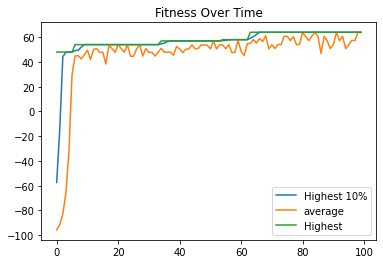

[0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 1. 0.]


In [23]:
##### Answers go here
def make_chromosome(chromosome_length):
  return np.around(np.random.random(chromosome_length))

def create_starting_population(chromosome_length, pop_size):
  return [make_chromosome(chromosome_length) for i in range(pop_size)]

population = create_starting_population(len(items), 100)

def get_phenotype(individual, items):
  filter = [np.concatenate(([individual],[individual]), axis=0).T==1]
  return np.sum(np.array(items.values*filter).reshape(len(items),-1), axis=0)

def score(individual, items):
  value, weights = get_phenotype(individual, items)
  score = value
  if weights > limit:
    score = -100
  return score

def score_pop(population, items):
  scores = []
  for individual in population:
    scores.append(score(individual, items))
  return scores

def sort_population(population, items):
  score_list = score_pop(population, items)
  sorted_pop = []
  sorted_indices = [x for y, x in sorted(zip(score_list, np.arange(len(score_list))))]
  for i in sorted_indices:
    sorted_pop.append(population[i].copy())
  return list(reversed(sorted_pop))

def reproduce(population):
  new_gen = population[:len(population)//2].copy()*2
  return new_gen

def mutate(population, probability):
  for i in range(len(population)):
    for ii in range(len(population[i])):
      if np.random.rand() < probability:
        population[i][ii] = np.abs(population[i][ii]-1)
  return population

def roulette_wheel(population, items, bias=3):
  sorted_pop = sort_population(population,items)
  scores = score_pop(sorted_pop,items)
  scores = list(np.array(scores)**(2**bias+1))
  integrated_scores = [np.sum(scores[:i]-np.min(scores)) for i in range(len(scores))]
  integrated_scores = integrated_scores / integrated_scores[-1]
  draws = []
  for i in range(len(population)):
    draw = np.random.rand()
    for ii in reversed(range(len(integrated_scores))):
      if draw > integrated_scores[ii]:
        draws.append(ii)
  return draws

def evolve(generations, n_items, pop_size, mut_rate):
  items, limit = make_items(n_items)

  top_10_fitness = []
  average_fitness = []
  top_fitness = []

  population = create_starting_population(n_items,pop_size)

  for i in range(generations):
    sorted_pop = sort_population(population,items)

    scores = score_pop(sorted_pop,items)
    top_10_fitness.append(np.average(scores[:10]))
    average_fitness.append(np.average(scores))
    top_fitness.append(np.average(scores[0]))

    new_population = reproduce(sorted_pop)
    new_population = mutate(new_population,mut_rate)
    population = new_population
  plt.plot(top_10_fitness,label="Highest 10%")
  plt.plot(average_fitness,label="average")
  plt.plot(top_fitness,label="Highest")
  plt.title("Fitness Over Time")
  plt.legend()
  plt.plot()
  plt.show()
  sorted_pop = sort_population(population,items)
  return sorted_pop,items

population, items = evolve(100,30,100,0.001)
print(population[0])

# Solutions (Genetic Algorithms 1)

Let's start by creating a chromosome. This will be an array of random ones and zeros as discussed in the lecture.

In [24]:
def make_chromosome(chromosome_length):
  return np.around(np.random.random(chromosome_length))

Once that is done we should be able to create the genome for one of our individuals.

In [25]:
chromosome = make_chromosome(len(items))
chromosome

array([1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.])

Now, with a simple loop we can use the function to create the whole starting generation 

In [26]:
def create_starting_population(chromosome_length, population_size):
  return [make_chromosome(chromosome_length) for i in range(population_size)]

That will look as follows:

In [27]:
population = create_starting_population(len(items),100)

Now we need a function to go from genotype to phenotype (how much weight & value does the gene represent). That will be needed in order to assign a score to the individual.

In [28]:
def get_phenotype(individual, items):
  filter = [np.concatenate(([individual],[individual]),axis=0).T==1]
  return np.sum(np.array(items.values*filter).reshape(len(items),-1),axis=0)

In [29]:
 value, weight = get_phenotype(chromosome,items)

Now we need our scoring function that allows us to check how well each individual is doing. 

In [30]:
def score(individual, items):
  value, weights = get_phenotype(individual, items)
  score = value
  if weights > limit:
    score-=100
  return score

Let's simply expand that to the entire population!

In [31]:
def score_population(population, items):
  scores = []
  for individual in population:
    scores.append(score(individual, items))
  return scores

And then write a function that can sort the population based on it's scores

In [32]:
def sort_population(population, items):
  score_list = score_population(population,items)
  sorted_population = []
  sorted_indices = [x for y, x in sorted(zip(score_list, np.arange(len(score_list))))]
  for i in sorted_indices:
    sorted_population.append(population[i].copy())
  return list(reversed(sorted_population))

Finally, we will 'kill' half of our individuals and duplicate the other half

In [33]:
def reproduce(population):
  n_individuals = len(population)
  new_generation = population[:n_individuals//2].copy()+population[:n_individuals//2].copy()
  return new_generation

Lastly, we write our mutation function that randomly flips 0s to 1s with a given probability

In [34]:
def mutate(population,probability):
  for i in range(len(population)):
    for ii in range(len(population[i])):
      random_number = np.random.rand()
      if random_number<probability:
        population[i][ii] = np.abs(population[i][ii]-1)
  return population

In the end we can put everything together into a single for loop that executes the genetic algorithm. We will store average score, average score of the top 10% and highest score so that we can use it to plot a graph of how our population evolved in the end!

In [35]:

def evolve(generations, n_items, limit, population_size, mutation_rate):
  items, limit = make_items(n_items)

  top_10_fitness = []
  average_fitness = []
  top_fitness = []

  population = create_starting_population(n_items,population_size)

  for i in range(generations):
    sorted_population = sort_population(population,items)

    scores = score_population(sorted_population,items)
    top_10_fitness.append(np.average(scores[:10]))
    average_fitness.append(np.average(scores))
    top_fitness.append(np.average(scores[0]))

    new_population = reproduce(sorted_population)
    new_population = mutate(new_population,mutation_rate)
    population = new_population
  plt.plot(top_10_fitness,label="Highest 10%")
  plt.plot(average_fitness,label="average")
  plt.plot(top_fitness,label="Highest")
  plt.title("Fitness over time")
  plt.legend()
  plt.plot()

  sorted_population = sort_population(population,items)
  return sorted_population,items

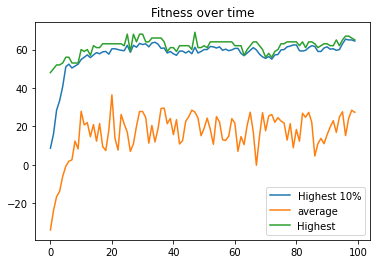

In [36]:
population, items = evolve(100,30,40,100,0.02)

As we can see, the genetic algorithm is learning over time - towards the end the mutation rate is too high so that the line is a bit 'fuzzy' if we let is run with a lower mutation rate:

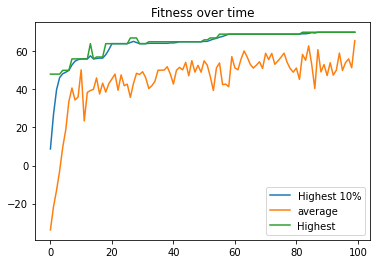

In [37]:
population,items = evolve(100,30,40,100,0.005)


With a higher mutation rate our solution becomes 'good' faster but the score keeps going up and down since the are many negative mutations. With a very low mutation rate the average score is much higher and the highest score is more consistent at the expense of using more epochs. Once we achieve an optimum we stay there, but it takes quite long to actually get there

In [38]:
# Now let's see what items our winner is taking:

items,limit = make_items(30)

filter = [np.concatenate(([population[0]],[population[0]]),axis=0).T==1]
np.array(items.values*filter).reshape(len(items),-1)

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 2.,  2.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 8.,  2.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 4.,  3.],
       [ 6.,  1.],
       [ 3.,  4.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 6.,  0.],
       [ 6.,  2.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 3.,  1.],
       [ 7.,  4.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 5.,  2.],
       [10.,  8.],
       [ 9.,  9.],
       [ 0.,  0.],
       [ 1.,  2.],
       [ 0.,  0.]])

And as we can see the winner takes items with a weight of 39 with it and a value of 71 (in my run - yours may differ)